# Mask Refine Demo

## Set Up & Configuration

First, we'll import the generally required packages:

In [1]:
import cv2
import imgaug.augmenters as iaa
import numpy as np
from os.path import exists

from mask_refine.mask_refine import MaskRefineSubnet
from mask_refine.mask_refine import MaskRefineModule
from opt_flow.opt_flow import TensorFlowPWCNet
from train.davis2017_dataset import *
from train.datautils import splitd
from train.viz import *

Using TensorFlow backend.


Now, we'll need to define some useful constants and parameters. (Change these to the appropriate numbers for your system and application.)

We're also creating the dataset and the generator here.

In [2]:
DATASET_PATH = '../data/DAVIS/'
OPTICAL_FLOW_WEIGHTS = './opt_flow/models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000'
MASK_REFINE_WEIGHTS = './logs/davis_unet_weights__30__0.10.h5'

assert exists(DATASET_PATH), 'Can\'t find path for dataset'
# we don't check the optical flow one, since that is only a 'virtual path' of sorts
assert exists(MASK_REFINE_WEIGHTS), 'Can\'t find path for mask refine model'

AUGMENTATION_SEQUENCE = iaa.Sequential([
    iaa.Multiply((0.25, 0.95)),
    iaa.ElasticTransformation(alpha=(2000, 10000), sigma=(20, 100)),
    iaa.GaussianBlur(sigma=(0, 20)),
    iaa.Sometimes(0.25, iaa.Multiply((0.5, 0.75))),
    iaa.MultiplyElementwise((0.8, 1.1)),
    iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(5, 100))),
    iaa.AdditiveGaussianNoise(scale=(1, 25))
])

DATASET = get_trainval(DATASET_PATH)
IMAGE_SHAPE = DATASET.size
GENERATOR = DATASET.paired_generator(AUGMENTATION_SEQUENCE)

Now, we create the optical flow model, the mask refine subnet, and the overall mask refine module.

In [3]:
pwc_net = TensorFlowPWCNet(IMAGE_SHAPE, model_pathname=OPTICAL_FLOW_WEIGHTS, verbose=True)

model_graph = pwc_net.graph

with model_graph.as_default():
    mr_subnet = MaskRefineSubnet(weights_path=MASK_REFINE_WEIGHTS)
    
    mr_module = MaskRefineModule(pwc_net, mr_subnet)

Building model...
... model built.
Loading model checkpoint ./opt_flow/models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000 for eval or testing...

INFO:tensorflow:Restoring parameters from ./opt_flow/models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000
... model loaded

Model Configuration:
  verbose                True
  ckpt_path              ./opt_flow/models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000
  x_dtype                <dtype: 'float32'>
  x_shape                [2, None, None, 3]
  y_dtype                <dtype: 'float32'>
  y_shape                [None, None, 2]
  gpu_devices            ['/device:GPU:0']
  controller             /device:GPU:0
  batch_size             1
  use_tf_data            True
  use_mixed_precision    False
  pyr_lvls               6
  flow_pred_lvl          2
  search_range           4
  use_dense_cx           True
  use_res_cx             True
  adapt_info             (1, 480, 854, 2)
  mode              

## Inference (on Random Image Pairs)

The following code snippet will run prediction and evaluation for a random image from the dataset.

In [18]:
input_stack, gt_mask = next(GENERATOR)

with model_graph.as_default():
    pred_mask = mr_module.refine_mask(input_stack)
    pred_metrics = mr_module.evaluate_mask(input_stack, gt_mask)

pred_mask = pred_mask[0, ...]

print(f'\nOUTPUT RESULTS:')
for metric, val in zip(mr_module.metrics, pred_metrics):
    print(f'\t{metric}:\t{val}')
    
# define the images/masks to be displayed
prev_image = input_stack[..., :3]
curr_image = input_stack[..., 3:6]
trans_mask = input_stack[..., 6].astype(int)
pred_mask = 1.0*pred_mask[..., 0]
gt_mask = gt_mask[..., 0].astype(int)

1/1 [==============================] - 27s 27s/step

OUTPUT RESULTS:
	loss:	0.10934434086084366
	binary_accuracy:	0.9652165174484253
	binary_crossentropy:	0.10934434086084366


In [19]:
with model_graph.as_default():
    of = pwc_net.infer_from_image_stack(np.concatenate([prev_image, curr_image], axis=2))
    
hsv = np.zeros(curr_image.shape, dtype=np.uint8)
hsv[..., 1] = 255

mag, ang = cv2.cartToPolar(of[..., 0], of[..., 1])
hsv[..., 0] = ang * 180 / np.pi / 2
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
of_polar = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

### Visualizations

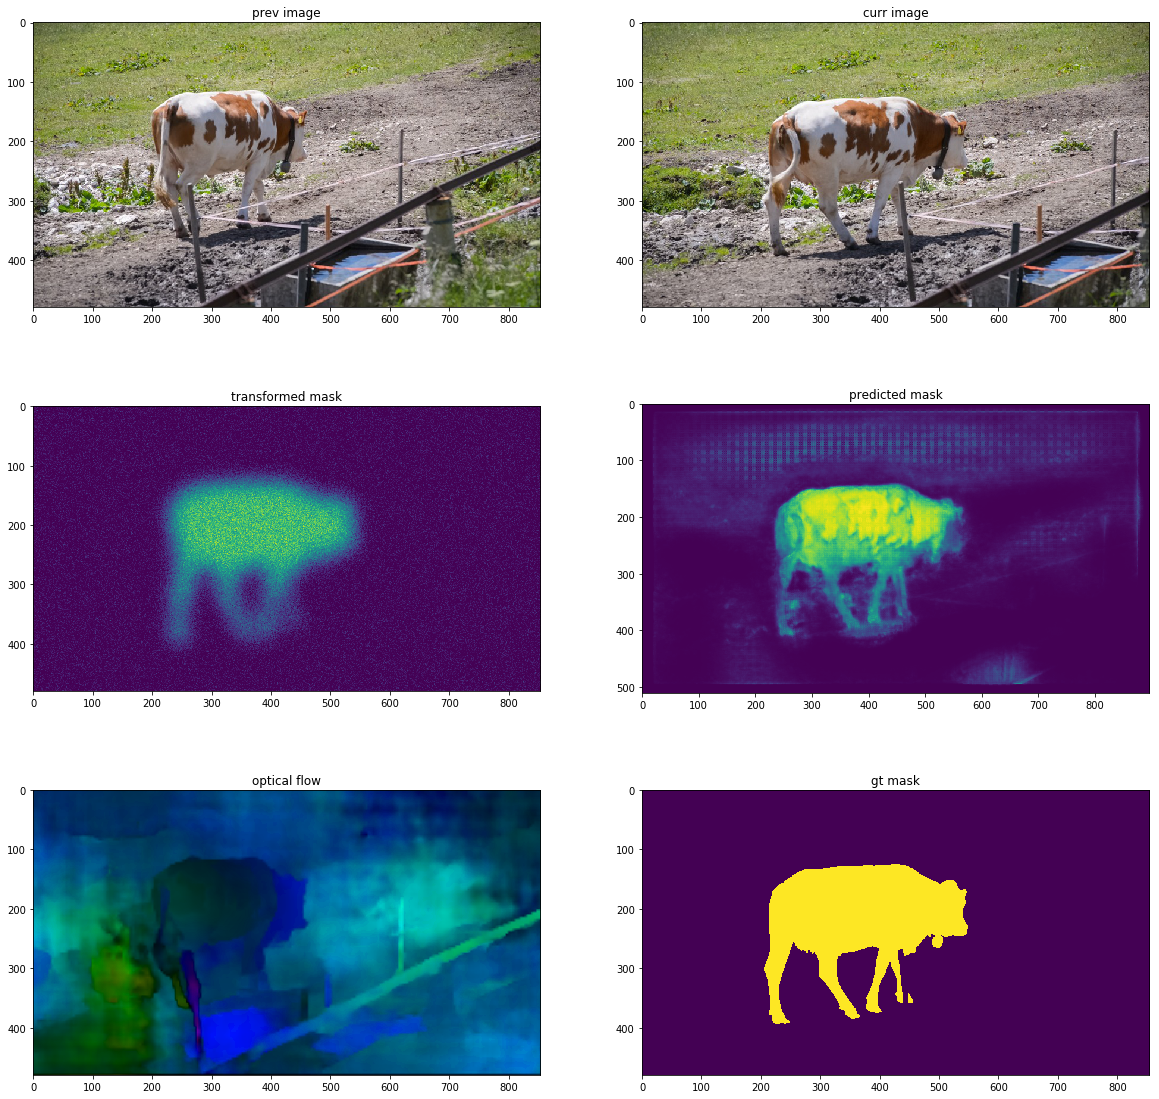

In [20]:
fig_save_path = './mask_refine/example.png'

vis_fix_col(prev_image, curr_image,
            trans_mask, pred_mask,
            of_polar, gt_mask,
            titles=['prev image', 'curr image',
                    'transformed mask', 'predicted mask',
                    'optical flow', 'gt mask'],
            figsize=(20, 20),
            save_path=fig_save_path)